# Вспомогательные функции для ядер и loss

In [ ]:
import numpy as np


def get_kernel(kernel_name, r=0, n=2, sigma=1, alpha=1):
    match kernel_name:
        case 'linear':
            return linear_kernel
        case 'polynomial':
            return lambda u, v: polynomial_kernel(r, n, u, v)
        case 'gaussian':
            return lambda u, v: gaussian_kernel(sigma, u, v)
        case 'laplacian':
            return lambda u, v: laplacian_kernel(alpha, u, v)
        case _:
            raise Exception('Unknown kernel specified: linear, polynomial, gaussian or laplacian are available.')


def get_kernel_gradient(kernel_name, r=0, n=2, sigma=1, alpha=1):
    match kernel_name:
        case 'linear':
            return linear_kernel_gradient
        case 'polynomial':
            return lambda X, y, w: polynomial_kernel_gradient(r, n, X, y, w)
        case 'gaussian':
            return lambda X, y, w: gaussian_kernel_gradient(sigma, X, y, w)
        case 'laplacian':
            return lambda X, y, w: laplacian_kernel_gradient(alpha, X, y, w)
        case _:
            raise Exception('Unknown kernel specified: linear, polynomial, gaussian or laplacian are available.')


def linear_kernel(u, v):
    return np.dot(u, v)


def polynomial_kernel(r, n, u, v):
    return (np.dot(u, v) + r) ** n


def gaussian_kernel(sigma, u, v):
    return np.exp(-(np.dot(u - v, u - v)) / (2 * sigma ** 2))


def laplacian_kernel(alpha, u, v):
    return np.exp(-alpha * np.linalg.norm(u - v, ord=2))


def linear_kernel_gradient(X, y, w):
    value = np.zeros(X.shape[1])
    for i in range(X.shape[0]):
        if y.iloc[i] * linear_kernel(X.iloc[i], w) < 1:
            value -= y.iloc[i] * X.iloc[i]
    return value


def polynomial_kernel_gradient(r, n, X, y, w):
    value = np.zeros(X.shape[1])
    for i in range(X.shape[0]):
        if y.iloc[i] * polynomial_kernel(r, n, X.iloc[i], w) < 1:
            value -= y.iloc[i] * n * (np.dot(X.iloc[i], w) + r) ** (n - 1) * X.iloc[i]
    return value


def gaussian_kernel_gradient(sigma, X, y, w):
    value = np.zeros(X.shape[1])
    sigma2 = sigma * sigma
    for i in range(X.shape[0]):
        if y.iloc[i] * gaussian_kernel(sigma, X.iloc[i], w) < 1:
            diff = X.iloc[i] - w
            value -= y.iloc[i] / sigma2 * np.exp(-np.dot(diff, diff) / (2 * sigma2)) * diff
    return value


def laplacian_kernel_gradient(alpha, X, y, w):
    value = np.zeros(X.shape[1])
    for i in range(X.shape[0]):
        if y.iloc[i] * laplacian_kernel(alpha, X.iloc[i], w) < 1:
            diff = X.iloc[i] - w
            norm = np.linalg.norm(diff, ord=2)
            value -= y.iloc[i] * alpha / norm * np.exp(-alpha * norm) * diff
    return value

In [ ]:
def get_loss(loss_name):
    match loss_name:
        case 'linear':
            return linear_loss
        case 'logarithmic':
            return logarithmic_loss
        case 'square':
            return square_loss
        case 'sigmoid':
            return sigmoid_loss
        case _:
            raise Exception('Unknown loss specified: '
                            'linear, logarithmic, square or sigmoid are available.')


def get_loss_gradient(loss_name):
    match loss_name:
        case 'linear':
            return linear_loss_gradient
        case 'logarithmic':
            return logarithmic_loss_gradient
        case 'square':
            return square_loss_gradient
        case 'sigmoid':
            return sigmoid_loss_gradient
        case _:
            raise Exception('Unknown loss specified: '
                            'linear, logarithmic, square or sigmoid are available.')


def linear_loss(X, y, w):
    value = 0
    n = X.shape[0]
    for i in range(n):
        value += max(0, -np.dot(X.iloc[i], w) * y.iloc[i])
    return value / n


def logarithmic_loss(X, y, w):
    value = 0
    n = X.shape[0]
    for i in range(n):
        value += np.log2(1 + np.exp(-np.dot(X.iloc[i], w) * y.iloc[i]))
    return value / n


def square_loss(X, y, w):
    value = 0
    n = X.shape[0]
    for i in range(n):
        m = np.dot(X.iloc[i], w) * y.iloc[i]
        value += (1 - m) * (1 - m)
    return value / n


def sigmoid_loss(X, y, w):
    value = 0
    n = X.shape[0]
    for i in range(n):
        value += 2 / (1 + np.exp(np.dot(X.iloc[i], w) * y.iloc[i]))
    return value / n


def linear_loss_gradient(X, y, w):
    value = np.zeros(X.shape[1])
    n = X.shape[0]
    for i in range(n):
        if np.dot(X.iloc[i], w) * y.iloc[i] <= 0:
            value -= y.iloc[i] * X.iloc[i]
    return value


def logarithmic_loss_gradient(X, y, w):
    value = np.zeros(X.shape[1])
    n = X.shape[0]
    for i in range(n):
        value += X.iloc[i] * y.iloc[i] / (1 + np.exp(y.iloc[i] * np.dot(X.iloc[i], w)))
    return -value


def square_loss_gradient(X, y, w):
    value = np.zeros(X.shape[1])
    n = X.shape[0]
    for i in range(n):
        value -= 2 * y.iloc[i] * (1 - y.iloc[i] * np.dot(X.iloc[i], w)) * X.iloc[i]
    return value


def sigmoid_loss_gradient(X, y, w):
    value = np.zeros(X.shape[1])
    n = X.shape[0]
    for i in range(n):
        sigmoid = 1 / (1 + np.exp(y.iloc[i] * np.dot(X.iloc[i], w)))
        value -= 2 * y.iloc[i] * sigmoid * (1 - sigmoid) * X.iloc[i]
    return value

# Мои реализации

In [ ]:
from numpy import dot, transpose, eye
from numpy.linalg import inv
from sklearn.metrics import f1_score

class MatrixRegressor:
    factors = None

    def fit(self, F, y, tau):
        self.factors = dot(
            dot(
                inv(
                    dot(transpose(F), F) + tau * eye(F.shape[1])
                ),
                transpose(F)
            ),
            y
        )

    def predict(self, X):
        return dot(X, self.factors)


class MatrixClassifier:
    regressor = MatrixRegressor()

    def fit(self, F, y, tau):
        self.regressor.fit(F, y, tau)

    def predict(self, X):
        return list(
            map(
                lambda x: 1 if x >= 0 else -1,
                self.regressor.predict(X)
            )
        )


class GDClassifier:
    loss = None
    loss_gradient = None
    l1 = 0
    l2 = 0
    lr = 1e-4
    epochs = 1
    h = 1e-6
    w = None
    train_history = None
    test_history = None

    def __init__(self, lr, epochs, loss='linear', l1=0, l2=0):
        self.loss = get_loss(loss)
        self.loss_gradient = get_loss_gradient(loss)
        self.l1 = l1
        self.l2 = l2
        self.lr = lr
        self.epochs = epochs

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        for epoch in range(self.epochs):
            gradient = self.loss_gradient(X, y, self.w) + self.l1 * np.sign(self.w) + 2 * self.l2 * self.w
            self.w -= self.lr * gradient

    def predict(self, X):
        return np.sign(dot(X, self.w))

    def debug_fit(self, X_train, y_train, X_test, y_test):
        self.w = np.zeros(X_train.shape[1])
        self.train_history = np.zeros(self.epochs)
        self.test_history = np.zeros(self.epochs)
        for epoch in range(self.epochs):
            gradient = self.loss_gradient(X_train, y_train, self.w) + self.l1 * np.sign(self.w) + 2 * self.l2 * self.w
            self.w -= self.lr * gradient
            self.train_history[epoch] = self.loss(X_train, y_train, self.w)
            self.test_history[epoch] = f1_score(y_test, self.predict(X_test))


class SVMClassifier:
    c = 1
    lr = 1e-4
    epochs = 1
    kernel = None
    kernel_gradient = None
    w = None
    train_history = None
    test_history = None

    def __init__(self, c, lr, epochs, kernel='linear', r=0, n=2, sigma=1, alpha=1):
        self.c = c
        self.kernel = get_kernel(kernel, r, n, sigma, alpha)
        self.kernel_gradient = get_kernel_gradient(kernel, r, n, sigma, alpha)
        self.lr = lr
        self.epochs = epochs

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        for epoch in range(self.epochs):
            gradient = self.kernel_gradient(X, y, self.w) + 1 / self.c * self.w
            self.w -= self.lr * gradient

    def predict(self, X):
        return np.array([1 if self.kernel(X.iloc[i], self.w) >= 0 else -1 for i in range(X.shape[0])])

    def debug_fit(self, X_train, y_train, X_test, y_test):
        self.w = np.zeros(X_train.shape[1])
        self.train_history = np.zeros(self.epochs)
        self.test_history = np.zeros(self.epochs)
        for epoch in range(self.epochs):
            gradient = self.kernel_gradient(X_train, y_train, self.w) + 1 / self.c * self.w
            self.w -= self.lr * gradient
            self.train_history[epoch] = self.loss(X_train, y_train)
            self.test_history[epoch] = f1_score(y_test, self.predict(X_test))

    def loss(self, X, y):
        value = 0
        n = X.shape[0]
        for i in range(n):
            value += max(0, 1 - dot(X.iloc[i], self.w) * y.iloc[i])
        return value / n

# Подготовка датасета

In [ ]:
!cp drive/MyDrive/us_cities.csv ./us_cities.csv

In [ ]:
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

feature = 'Region'
size = 1000
train_ratio = 0.8

df = pd.read_csv('us_cities.csv')
df = df.dropna(ignore_index=True)
df[feature] = df[feature].map({'West': -1, 'Midwest': -1, 'Northeast': 1, 'South': 1})
df = df.iloc[:, 1:].drop(columns=['City', 'State', 'County', 'Division', 'Longitude', 'Latitude'])
for column in df:
    if column != 'Region':
        mean = df[column].mean()
        std = df[column].std()
        outliers = np.where((df[column] - mean) / std >= 3)[0]
        df = df.drop(index=outliers).reset_index(drop=True)

west_df = resample(df.loc[df[feature] == -1], n_samples=size).reset_index(drop=True)
east_df = resample(df.loc[df[feature] == 1], n_samples=size).reset_index(drop=True)
df = pd.concat([west_df, east_df])
target = pd.Series(df[feature])
df = df.drop(columns=[feature])
df = (df - df.mean()) / df.std()
X_train, X_test, y_train, y_test = train_test_split(df, target, train_size=train_ratio)

# Настройка гиперпараметров

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.4 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.metrics import f1_score

train_size = int(X_train.shape[0] * train_ratio)
train_data = X_train[: train_size]
valid_data = X_train[train_size:]
train_target = y_train[: train_size]
valid_target = y_train[train_size :]

In [ ]:
def gd_objective(trial):
    lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
    epochs = trial.suggest_int('epochs', 10, 100)
    loss = trial.suggest_categorical('loss', ['linear', 'logarithmic', 'square', 'sigmoid'])
    l1 = trial.suggest_float('l1', 1e-2, 1, log=True)
    l2 = trial.suggest_float('l2', 1e-2, 1, log=True)
    classifier = GDClassifier(lr, epochs, loss, l1, l2)
    classifier.fit(train_data, train_target)
    return f1_score(valid_target, classifier.predict(valid_data))

study = optuna.create_study(direction='maximize')
study.optimize(gd_objective, n_trials=100)
print(study.best_params)

[I 2024-10-16 19:35:21,342] A new study created in memory with name: no-name-537a89c5-474d-47f8-915a-5e5c1c13276f
[I 2024-10-16 19:36:52,234] Trial 0 finished with value: 0.7671232876712328 and parameters: {'lr': 0.0005132687797592293, 'epochs': 99, 'loss': 'logarithmic', 'l1': 0.7171136260774637, 'l2': 0.011436156669803627}. Best is trial 0 with value: 0.7671232876712328.
[I 2024-10-16 19:37:25,247] Trial 1 finished with value: 0.625 and parameters: {'lr': 0.002657186536836602, 'epochs': 79, 'loss': 'linear', 'l1': 0.10085336982091044, 'l2': 0.10759692127781532}. Best is trial 0 with value: 0.7671232876712328.
[I 2024-10-16 19:38:30,306] Trial 2 finished with value: 0.7087719298245614 and parameters: {'lr': 1.5509298369795495e-05, 'epochs': 60, 'loss': 'logarithmic', 'l1': 0.1823611530335368, 'l2': 0.013079868434624482}. Best is trial 0 with value: 0.7671232876712328.
[I 2024-10-16 19:39:17,352] Trial 3 finished with value: 0.698961937716263 and parameters: {'lr': 1.17845166216751e-06

{'lr': 0.0001123614944928394, 'epochs': 42, 'loss': 'square', 'l1': 0.0268516397217715, 'l2': 0.3424604625781282}


In [ ]:
def svm_objective(trial):
    c = trial.suggest_float('C', 1e-2, 1e2, log=True)
    lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
    epochs = trial.suggest_int('epochs', 10, 100)
    kernel = trial.suggest_categorical('kernel', ['linear', 'polynomial', 'gaussian', 'laplacian'])
    r, n, sigma, alpha = 0, 2, 1, 1
    if kernel == 'polynomial':
        r = trial.suggest_float('r', 0, 1)
        n = trial.suggest_int('n', 1, 2)
    if kernel == 'gaussian':
        sigma = trial.suggest_float('sigma', 1e-1, 10, log=True)
    if kernel == 'laplacian':
        alpha = trial.suggest_float('alpha', 1e-1, 10, log=True)
    classifier = SVMClassifier(c, lr, epochs, kernel, r, n, sigma, alpha)
    classifier.fit(train_data, train_target)
    return f1_score(valid_target, classifier.predict(valid_data))

study = optuna.create_study(direction='maximize')
study.optimize(svm_objective, n_trials=100)
print(study.best_params)

[I 2024-10-16 21:09:57,507] A new study created in memory with name: no-name-93dab4b9-3299-47be-ac19-cbae7faf12d5
[I 2024-10-16 21:11:30,325] Trial 0 finished with value: 0.6721991701244814 and parameters: {'C': 45.16986672108772, 'lr': 0.0013406949977106681, 'epochs': 59, 'kernel': 'gaussian', 'sigma': 5.313909188983047}. Best is trial 0 with value: 0.6721991701244814.
[I 2024-10-16 21:12:53,525] Trial 1 finished with value: 0.7443181818181818 and parameters: {'C': 21.631326675221942, 'lr': 2.9735885682471593e-05, 'epochs': 79, 'kernel': 'polynomial', 'r': 0.4088981912116728, 'n': 1}. Best is trial 1 with value: 0.7443181818181818.
[I 2024-10-16 21:13:26,211] Trial 2 finished with value: 0.6721991701244814 and parameters: {'C': 0.7957812304738692, 'lr': 0.006261117112839037, 'epochs': 53, 'kernel': 'polynomial', 'r': 0.8377701573496685, 'n': 2}. Best is trial 1 with value: 0.7443181818181818.
[I 2024-10-16 21:13:42,541] Trial 3 finished with value: 0.6721991701244814 and parameters: {

{'C': 46.60277871020312, 'lr': 0.00017267720954344096, 'epochs': 70, 'kernel': 'linear'}


For GradientDescent:
```
{'lr': 0.0001123614944928394, 'epochs': 42, 'loss': 'square', 'l1': 0.0268516397217715, 'l2': 0.3424604625781282}
```

For SVM:
```
{'C': 46.60277871020312, 'lr': 0.00017267720954344096, 'epochs': 70, 'kernel': 'linear', 'r': 0.87, 'n': 1}
```

# Кривые обучения

In [ ]:
gd_classifier = GDClassifier(lr=0.0001124, epochs=100, loss='square', l1=0.027, l2=0.342)
gd_classifier.debug_fit(X_train, y_train, X_test, y_test)

In [ ]:
svm_classifier = SVMClassifier(c=46.603, lr=0.0001727, epochs=100, kernel='linear', r=0.87, n=1)
svm_classifier.debug_fit(X_train, y_train, X_test, y_test)

In [ ]:
matrix_classifier = MatrixClassifier()
matrix_classifier.fit(X_train, y_train, 0.011)
matrix_test = np.full(100, f1_score(y_test, matrix_classifier.predict(X_test)))

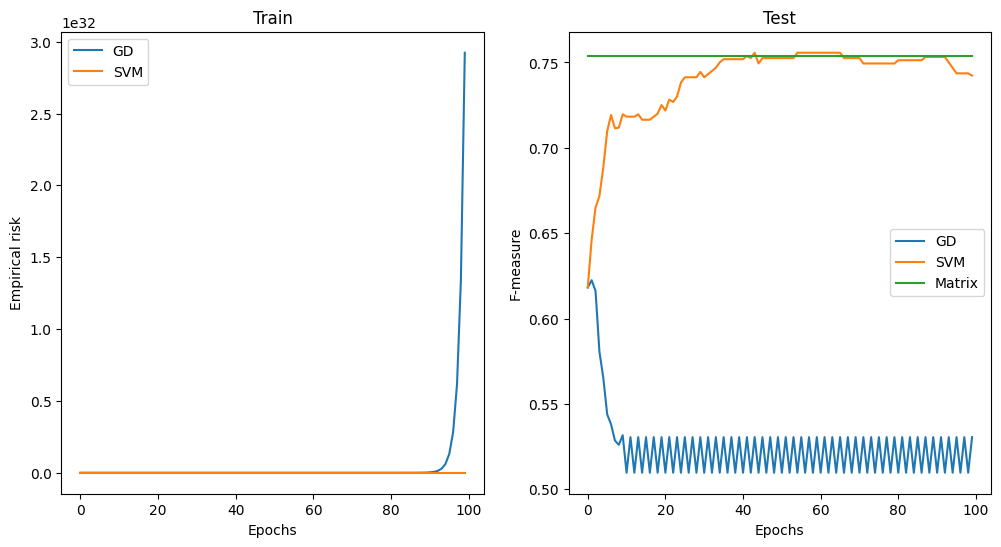

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Train')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Empirical risk')
ax[0].plot(gd_classifier.train_history, label='GD')
ax[0].plot(svm_classifier.train_history, label='SVM')
ax[0].legend()

ax[1].set_title('Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('F-measure')
ax[1].plot(gd_classifier.test_history, label='GD')
ax[1].plot(svm_classifier.test_history, label='SVM')
ax[1].plot(matrix_test, label='Matrix')
ax[1].legend()

# Библиотечные реализации

In [ ]:
from sklearn.linear_model import ElasticNet

def en_objective(trial):
    alpha = trial.suggest_float('alpha', 1e-2, 1, log=True)
    l1 = trial.suggest_float('l1', 1e-2, 1, log=True)
    classifier = ElasticNet(alpha=alpha, l1_ratio=l1)
    classifier.fit(train_data, train_target)
    prediction = classifier.predict(valid_data)
    return f1_score(valid_target, np.array([1 if prediction[i] >= 0 else -1 for i in range(len(prediction))]))

study = optuna.create_study(direction='maximize')
study.optimize(en_objective, n_trials=100)
print(study.best_params)

[I 2024-10-16 22:46:55,260] A new study created in memory with name: no-name-0d978b0d-9c8c-4b4d-9285-100ef89f59eb
[I 2024-10-16 22:46:55,384] Trial 0 finished with value: 0.7651006711409396 and parameters: {'alpha': 0.010208506926109775, 'l1': 0.020701450408656598}. Best is trial 0 with value: 0.7651006711409396.
[I 2024-10-16 22:46:55,435] Trial 1 finished with value: 0.7708333333333334 and parameters: {'alpha': 0.5938704558749004, 'l1': 0.02300873175835592}. Best is trial 1 with value: 0.7708333333333334.
[I 2024-10-16 22:46:55,484] Trial 2 finished with value: 0.7482517482517482 and parameters: {'alpha': 0.32189531835717333, 'l1': 0.14212281441731883}. Best is trial 1 with value: 0.7708333333333334.
[I 2024-10-16 22:46:55,538] Trial 3 finished with value: 0.0 and parameters: {'alpha': 0.7655501983628005, 'l1': 0.9685242799359596}. Best is trial 1 with value: 0.7708333333333334.
[I 2024-10-16 22:46:55,567] Trial 4 finished with value: 0.7785234899328859 and parameters: {'alpha': 0.03

{'alpha': 0.1748709061208027, 'l1': 0.03466659272710724}


In [ ]:
from sklearn.svm import SVC

def svc_objective(trial):
    c = trial.suggest_float('C', 1e-2, 1e2, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree, coef0 = 1, 0
    if kernel == 'poly':
        degree = trial.suggest_int('degree', 1, 3)
        coef0 = trial.suggest_float('coef0', 0, 2)
    if kernel == 'sigmoid':
        coef0 = trial.suggest_float('coef0', 0, 2)
    classifier = SVC(C=c, kernel=kernel, degree=degree, coef0=coef0)
    classifier.fit(train_data, train_target)
    return f1_score(valid_target, classifier.predict(valid_data))

study = optuna.create_study(direction='maximize')
study.optimize(svc_objective, n_trials=100)
print(study.best_params)

[I 2024-10-16 22:47:12,879] A new study created in memory with name: no-name-69f471d2-05f2-4d61-b89b-85fe13b88459
[I 2024-10-16 22:47:13,164] Trial 0 finished with value: 0.7536231884057971 and parameters: {'C': 0.4379074148468777, 'kernel': 'linear'}. Best is trial 0 with value: 0.7536231884057971.
[I 2024-10-16 22:47:13,728] Trial 1 finished with value: 0.5416666666666666 and parameters: {'C': 0.6890307270539315, 'kernel': 'sigmoid', 'coef0': 1.610208528563768}. Best is trial 0 with value: 0.7536231884057971.
[I 2024-10-16 22:47:17,031] Trial 2 finished with value: 0.7345454545454545 and parameters: {'C': 32.733591610765316, 'kernel': 'linear'}. Best is trial 0 with value: 0.7536231884057971.
[I 2024-10-16 22:47:17,465] Trial 3 finished with value: 0.012269938650306749 and parameters: {'C': 0.010260164832874737, 'kernel': 'sigmoid', 'coef0': 1.7768421277425168}. Best is trial 0 with value: 0.7536231884057971.
[I 2024-10-16 22:47:17,687] Trial 4 finished with value: 0.5333333333333333

{'C': 81.36884338144257, 'kernel': 'rbf'}


EN:
```
{'alpha': 0.1748709061208027, 'l1': 0.03466659272710724}
```
SVC:
```
{'C': 81.36884338144257, 'kernel': 'rbf'}
```

## Кривые обучения

In [ ]:
en_classifier = ElasticNet(alpha=0.175, l1_ratio=0.0347)
en_classifier.fit(X_train, y_train)
prediction = en_classifier.predict(X_test)
en_result = f1_score(y_test, np.array([1 if prediction[i] >= 0 else -1 for i in range(len(prediction))]))

In [ ]:
svc_classifier = SVC(C=81.3688, kernel='rbf')
svc_classifier.fit(X_train, y_train)
svc_result = f1_score(y_test, svc_classifier.predict(X_test))

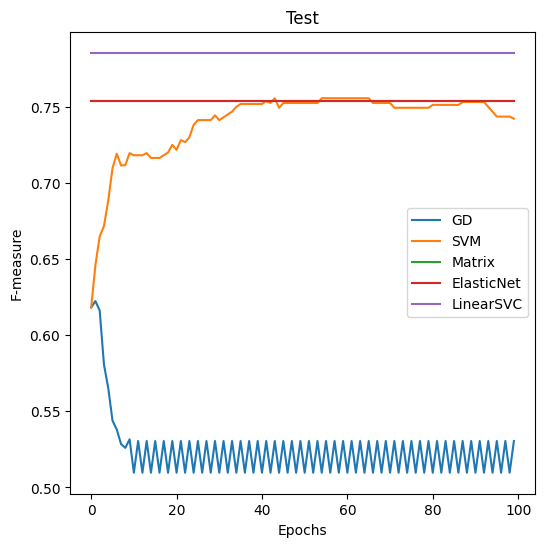

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.set_title('Test')
ax.set_xlabel('Epochs')
ax.set_ylabel('F-measure')
ax.plot(gd_classifier.test_history, label='GD')
ax.plot(svm_classifier.test_history, label='SVM')
ax.plot(matrix_test, label='Matrix')
ax.plot(np.full(100, en_result), label='ElasticNet')
ax.plot(np.full(100, svc_result), label='LinearSVC')
ax.legend()

# Сравнение

## MyGD VS ElasticNet

In [ ]:
from sklearn.metrics import mean_squared_error

gd_factors = pd.Series(gd_classifier.w, name='GD')
en_factors = pd.Series(en_classifier.sparse_coef_.toarray().flatten(), index=gd_classifier.w.index, name='ElasticNet')
print(pd.DataFrame([gd_factors, en_factors]).transpose())
print('MSE: ', mean_squared_error(gd_classifier.w, en_classifier.sparse_coef_.toarray().flatten()))

                                 GD  ElasticNet
Population            -2.280221e+15    0.003997
Asian                 -1.607178e+15    0.016060
White                 -2.222631e+15    0.000000
Black                 -1.198569e+15    0.144276
Indian                -7.974989e+14    0.014324
Hispanic              -1.444320e+15    0.039645
Hawaiian              -9.775641e+14   -0.077113
Other                 -1.540850e+15    0.000000
Females               -2.314989e+15    0.039074
Males                 -2.324313e+15    0.018778
Median_age             1.198198e+15    0.000000
Median_female_age      1.087015e+15    0.005082
Median_male_age        1.226148e+15   -0.028912
Households            -2.266946e+15    0.027292
Persons_per_household -5.140082e+14    0.069803
Household_income      -5.668231e+14   -0.134121
Total_area            -4.495736e+14    0.059375
Land_area             -4.514370e+14    0.058673
Water_area            -1.753251e+14    0.014537
Elevation              5.457257e+14   -0

## MySVM VS SVC

In [ ]:
svc_classifier.support_vectors_

array([[-0.77194937, -0.37452484, -0.84690516, ..., -0.23491871,
         0.25209082,  0.68836648],
       [-0.44287791, -0.37452484, -0.4331379 , ..., -0.23491871,
        -0.20869429, -0.1685777 ],
       [ 2.97903521,  3.39816128,  3.14368369, ...,  1.58388709,
        -1.07398542,  2.97649031],
       ...,
       [ 1.84583566, -0.12616619,  2.07272115, ..., -0.19866344,
         0.02345699, -0.22812987],
       [ 0.94519071, -0.00790017,  1.06216259, ..., -0.23491871,
         0.14305007,  0.18405971],
       [-0.31463682, -0.161646  , -0.40656015, ...,  2.49026872,
        -0.54636888, -0.7712768 ]])

In [ ]:
support_vectors = []
for i in range(X_train.shape[0]):
    m = np.dot(X_train.iloc[i], svm_classifier.w) * y_train.iloc[i]
    if 0.9 <= m <= 1.1:
        support_vectors.append(X_train.iloc[i])
np.asarray(support_vectors)

array([[-0.70070432, -0.33904503, -0.76807796, ...,  0.91920723,
        -0.52526422, -0.9089194 ],
       [-0.25468344, -0.31539183, -0.267631  , ..., -0.23491871,
         0.07621864, -0.17390951],
       [-0.21274296, -0.23260561,  0.05190604, ..., -0.23491871,
        -0.38456647,  1.0820588 ],
       ...,
       [-0.75958231, -0.37452484, -0.78499108, ..., -0.23491871,
         0.76915503, -0.32762956],
       [-0.7638839 , -0.37452484, -0.83784456, ..., -0.23491871,
        -0.2333164 , -0.52548056],
       [-0.63134122, -0.35087164, -0.63337709, ..., -0.22283362,
        -0.38456647, -0.81134736]])